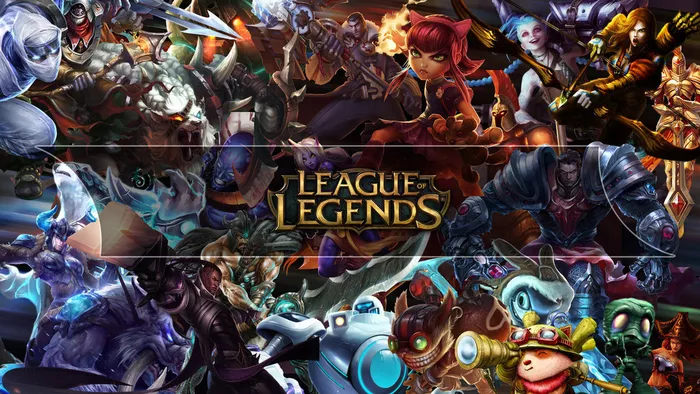

# Deciding Factors in League of Legends

### This notebooks tries to find out what are the key reasons a team wins/loses, and at the same time build a model predicting game results only using data from the first 10 mins. The data consists of SOLO QUEUE games at high ELO (DIAMOND I to MASTER)

### The algorithms used are:
* Random Forest
* Logistic Regression
* Principal Compnent Analysis (PCA)

### Summary of findings:

The two most important statistics on winning/losing are:
* Gold difference
* Experience difference

## Load Libraries

In [ ]:
import numpy as np 
import pandas as pd

# graphics
import seaborn as sns
import matplotlib.pyplot as plt

# plotly
import plotly as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.express as px
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [ ]:
games_source = pd.read_csv('../input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv')

# Basic info

In [ ]:
print('data dimension:', games_source.shape)
print('\n')
print('column names:', list(games_source.columns))
print('\n')
print('missing values:', games_source.isnull().any().sum())
print('\n')
games_source.head(10)

In [ ]:
# make a copy of data, set gameId to index
games = games_source.copy()
games.drop(columns='gameId', inplace=True)
games.iloc[0,:]

# Data cleaning
## Remove redundant variables

Clearly, some of the variables are not needed

* some variables have correlation = -1, e.g. `blueKills` = `redDeaths` * -1
* some variables can be calculated using other variables, e.g. `blueGoldDiff` = `blueTotalGold` - `redTotalGold`


In [ ]:
# heatmap
corr = games.corr()

plt.figure(figsize=(18,18))
sns.heatmap(corr, square=True)
plt.show()

## Remove variables that can be calculated by others

* `blueTotalGold`, `blueTotalExperience`, `blueTotalMinionsKilled`, `blueCSPerMin`, `blueGoldPerMin`, `blueAvgLevel`
* `redFirstBlood`, `redGoldDiff`, `redExperienceDiff` `redKills`, `redDeaths`, `redAssists`, `redTotalGold`, `redTotalExperience`, `redTotalMinionsKilled`, `redCSPerMin`, `redGoldPerMin`, `redAvgLevel`

### Some of the reasons are:

Variables such as `CS per min`, `minions kill` are all reflected in `gold differeneces`

`redFirstBlood` and `blueFirstBlood` are complete opposite so only need to keep one of them


In [ ]:
games.drop(columns=['blueTotalGold', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueCSPerMin', 'blueGoldPerMin', 'blueAvgLevel'], inplace=True)
games.drop(columns=['redFirstBlood', 'redGoldDiff', 'redExperienceDiff', 'redKills', 'redDeaths', 'redAssists', 'redTotalGold', 
                    'redTotalExperience', 'redTotalMinionsKilled', 'redGoldPerMin', 'redAvgLevel', 'redCSPerMin'], inplace=True)

In [ ]:
# heatmap
corr = games.corr()

plt.figure(figsize=(18,18))
sns.heatmap(corr, annot=True, square=True)
plt.show()

## Count number of wins on each side, data look quite balanced

In [ ]:
# count blueWins

plt.figure(figsize=(6,6))
sns.countplot(data=games, x='blueWins')
plt.title('Distribution of Blue Side win/lose', size=19)
plt.show()

## Split data into train and test 

In [ ]:
# train, test split
X = games.iloc[:,1:]
y = games['blueWins']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print('\n')
print('mean gold diff:', x_train['blueGoldDiff'].mean())
print('mean exp diff:', x_train['blueExperienceDiff'].mean())

## Make sure the classes are balanced

In [ ]:
# count blueWins
y_train_count = pd.DataFrame({'blueWins':y_train})
y_test_count = pd.DataFrame({'blueWins':y_test})

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,6))

sns.countplot(data=y_train_count, x='blueWins', ax=ax1)
ax1.set_title('Training set')
ax1.grid(False)

sns.countplot(data=y_test_count, x='blueWins',ax=ax2)
ax2.set_title('test set')
ax2.grid(False)

plt.suptitle('Distribution of Blue Side win/lose', size=20)
plt.show()

# Random Forest

First fit a basic Random Forest model

In [ ]:
model = RandomForestClassifier(random_state=10)
model.fit(x_train, y_train)
model.score(x_test, y_test)

## Important features in Random Forest

It seems like `blueGoldDiff` and `blueExperienceDiff` are the most significant factors (this is intuitively correct if you play the game)

In [ ]:
important_features = pd.DataFrame({'feature':x_train.columns, 'importance_score':model.feature_importances_})
important_features.sort_values(by='importance_score', ascending=False, inplace=True)

plt.figure(figsize=(24,6))
p = sns.barplot(data=important_features, x='feature', y='importance_score')

plt.xticks(rotation=65)
plt.show()

## Fine Tuning Hyperparameters using `RandomizedSearchCV`

### This takes a long time to run, uncomment the code if you want to run it yourself

In [ ]:
# # set range of parameters for tuning
# n_estimators = [int(x) for x in np.linspace(start=50, stop=2000, num=79)]
# criterion = ['gini', 'entropy']
# max_features = ['auto','sqrt','log2',None]
# max_depth = [int(x) for x in np.linspace(start=5, stop=25, num=20)]
# max_depth.append(None)
# min_samples_split = [2,5,8]
# min_samples_leaf = [1, 2, 4]

# parameters = {'n_estimators' : n_estimators,
#                  'criterion' : criterion,
#                  'max_features' : max_features,
#                  'max_depth' : max_depth,
#                  'min_samples_split' : min_samples_split,
#                  'min_samples_leaf' : min_samples_split}


# rdm_for = RandomForestClassifier()
# rdm_CV = RandomizedSearchCV(rdm_for, parameters, cv=5, n_iter = 10, verbose=1)
# rdm_CV.fit(X,y)

# rdm_CV.best_params_
# # {'n_estimators': 950,
# #  'min_samples_split': 8,
# #  'min_samples_leaf': 1,
# #  'max_features': 'auto',
# #  'max_depth': 7,
# #  'criterion': 'gini'}

### Fit the model using results from random search

In [ ]:
model = RandomForestClassifier(n_estimators=950, 
                               min_samples_split=8, 
                               min_samples_leaf=1, 
                               max_features='auto',
                              max_depth=7,
                              criterion='gini',
                              random_state=10)
model.fit(x_train, y_train)
model.score(x_test, y_test)


# Logistic Regression

In [ ]:
# logistice regression
clf = LogisticRegression()
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

## Logistic Regression - Hyperparameter Tuning

In [ ]:
# set range of parameters for tuning
C = np.arange(0.00001, 5, 0.1)
penalty = ['l1', 'l2', 'elasticnet', 'none']


parameters = {'C' : C,'penalty' : penalty}


clf = LogisticRegression()
clf_CV = RandomizedSearchCV(clf, parameters, cv=5, n_iter = 10, verbose=1)
clf_CV.fit(X,y)

# clf_CV.best_params_
# {'penalty': 'l2', 'C': 4.50001}

In [ ]:
# logistice regression after fine tuning
clf = LogisticRegression(penalty='l2', C=4.5)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

## Principal Component Analysis (PCA)

### Standardize the data, then perform PCA

In [ ]:
# make a copy of data, set gameId to index
games = games_source.copy()
games.drop(columns='gameId', inplace=True)

X = games.iloc[:,1:]
y = games['blueWins']


# Standardize
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components='mle', svd_solver='full')
pca.fit(X_scaled)


## Explained variance by each component

* The first component is fairly dominant compare to others, explaining over 30% of total variance
* The first 15 components explains over 90% of total variance

In [ ]:
# var ratio
variance_ratio = pd.DataFrame({'Component':range(0,25), 'Percentage_explained_variance':pca.explained_variance_ratio_})
variance_ratio

plt.figure(figsize=(24,6))
sns.barplot(data=variance_ratio, x='Component', y='Percentage_explained_variance')
plt.title('Percentage of Variance Explained', size=25)
plt.show()

# cumulative sum
cumsum_ratio = pd.DataFrame({'Component':range(0,25), 'Cumulative_sum':pca.explained_variance_ratio_.cumsum()})

plt.figure(figsize=(24,6))
sns.set_style("whitegrid")
sns.lineplot(data=cumsum_ratio, x='Component', y='Cumulative_sum')
plt.title('Cumulative Sum of Variance Explained', size=25)
plt.xticks(np.arange(0,26, step=1))
plt.show()

## Examine important features in first few components

### Take a look at highest eigenvalues in the first few components, identify important features

### Component 1

* Gold difference 
* Experience difference

In [ ]:
aa = pd.DataFrame({'feature':X.columns, 'eigenvalue': abs(pca.components_[0])})
aa.sort_values(by='eigenvalue', ascending=False).head(10)

### Component 2

* Kills / Deaths / Assists

In [ ]:
aa = pd.DataFrame({'feature':X.columns, 'eigenvalue': abs(pca.components_[1])})
aa.sort_values(by='eigenvalue', ascending=False).head(10)

### Component 3

* Elite monsters, includes dragons and Heralds
* Interestingly the eigenvalue is not that big for Heralds, this might be due to early tower damage does not have hugh impact unless the team can snowball really well with the vision advantage. Or the Herald could be traded with Dragon kill from the other team, but Dragons are more valuable.

In [ ]:
aa = pd.DataFrame({'feature':X.columns, 'eigenvalue': abs(pca.components_[2])})
aa.sort_values(by='eigenvalue', ascending=False).head(10)

### Component 4

* Again, experience of players (equivalent to average level)

In [ ]:
aa = pd.DataFrame({'feature':X.columns, 'eigenvalue': abs(pca.components_[3])})
aa.sort_values(by='eigenvalue', ascending=False).head(10)

## Fitting Random Forest using the PCA transformed X

In [ ]:
new_x = pca.transform(X_scaled)
new_x = pd.DataFrame(new_x)
new_x

In [ ]:
# train, test split
X = new_x.copy()
y = games['blueWins']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

### Not much of improvement

In [ ]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
model.score(x_test, y_test)


# Conclusion

**Gold Difference** and **Experience Difference** are the two greatest factors in the game, any actions that enlarge the gap of gold and experience will help teams towards victory.

Regarding prediction accuracy, is it impossible to be close to 100% because the data is only for first 10 minutes and an average game can last between 25 -35 minutes. Also comebacks do happen from time to time and numerical advantage on certain stats does not guarantee victory.